# Linear Models

In [2590]:
# Librerie base
import numpy as np
import pandas as pd

# Visualizzazione
import matplotlib.pyplot as plt  
import seaborn as sns

# Modelli statistici
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor as VIF
from statsmodels.stats.anova import anova_lm

# Libreria ISLP (Statistical Learning)
from ISLP import load_data
from ISLP.models import (ModelSpec as MS ,summarize, poly)

### usiamo i dati engineered con log-price

In [2591]:
data=pd.read_csv("Data/aircraft_price_Engineered.csv")
data.columns

Index(['price', 'roc_mean', 'speed_margin', 'power_per_distance', 'wing_span',
       'range'],
      dtype='object')

In [2592]:
numeric_data=data.select_dtypes(include=[np.number])
numeric_data

,price,roc_mean,speed_margin,power_per_distance,wing_span,range
0,14.077876,675.0,58.0,0.111538,449.0,370.0
1,14.022526,660.0,45.0,0.106250,433.0,190.0
2,14.285515,562.5,53.0,0.105882,420.0,210.0
3,14.077876,560.0,51.0,0.100000,420.0,210.0
4,14.038655,501.0,50.0,0.073446,420.0,175.0
...,...,...,...,...,...,...
502,15.226498,2586.0,295.0,0.438596,572.0,1879.0
503,15.091990,2330.0,223.0,0.236609,572.0,1722.0
504,14.978662,2733.0,203.0,0.238648,572.0,1515.0
505,14.991084,2345.0,198.0,0.253475,512.0,1336.0


## Simple Linear Regression

### Ordering the 3 variables for the more promising

In [2593]:
# Target variable

results = []
target = 'price'

# Looping every possible variable
for col in numeric_data:
    X = sm.add_constant(data[[col]])
    y = data[target]
    
    model = sm.OLS(y, X).fit()
    
    results.append({
        'variable': col,
        'r_squared': model.rsquared,
        'p_value': model.pvalues[col]
    })

# Transforming data frame
results_df = pd.DataFrame(results)

# Ordering
top_r2_pval = results_df.sort_values(by='p_value', ascending=True).head(4)


# Output
print("VARIABILI CON R² PIU' ALTO E p-value PIU BASSO:")
print(top_r2_pval)

VARIABILI CON R² PIU' ALTO E p-value PIU BASSO:
       variable  r_squared        p_value
0         price   1.000000   0.000000e+00
2  speed_margin   0.606928  1.828944e-104
1      roc_mean   0.566798   8.651730e-94
5         range   0.479449   1.305528e-73


### Fit linear model price = b0 + b1*speed_margin + e

In [2594]:
X= pd.DataFrame({'Intercept': np.ones(data.shape[0]), 'speed_margin': data['speed_margin']})
X[:5]

,Intercept,speed_margin
0,1.0,58.0
1,1.0,45.0
2,1.0,53.0
3,1.0,51.0
4,1.0,50.0


In [2595]:
y = data[target]
model = sm.OLS(y, X) #function to fit a simple linear regression. Here we define the model
results = model.fit() #here we fit the model

In [2596]:
print(results.summary())

#print R² and MSE
print("R²: ", results.rsquared)

#converti y de-log  trasformando e poi calcola MSE
y_pred = results.predict(X)
y_pred[:5]
y_pred = np.exp(y_pred)
y_pred[:5]
y[:5]
y_true = np.exp(y)
y[:5]
mse = np.mean((y_true - y_pred) ** 2)
#RMSE
rmse = np.sqrt(mse)
print("RMSE: ", rmse)



                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.607
Model:                            OLS   Adj. R-squared:                  0.606
Method:                 Least Squares   F-statistic:                     779.8
Date:                Thu, 01 May 2025   Prob (F-statistic):          1.83e-104
Time:                        18:56:15   Log-Likelihood:                -33.517
No. Observations:                 507   AIC:                             71.03
Df Residuals:                     505   BIC:                             79.49
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       14.1086      0.021    681.685   

### Creating the input matrix using ModelSpec of ISLP package

In [2597]:
model = MS(['speed_margin'])
model = model.fit(data) 
X = model.transform(data)
X[:4]

,intercept,speed_margin
0,1.0,58.0
1,1.0,45.0
2,1.0,53.0
3,1.0,51.0


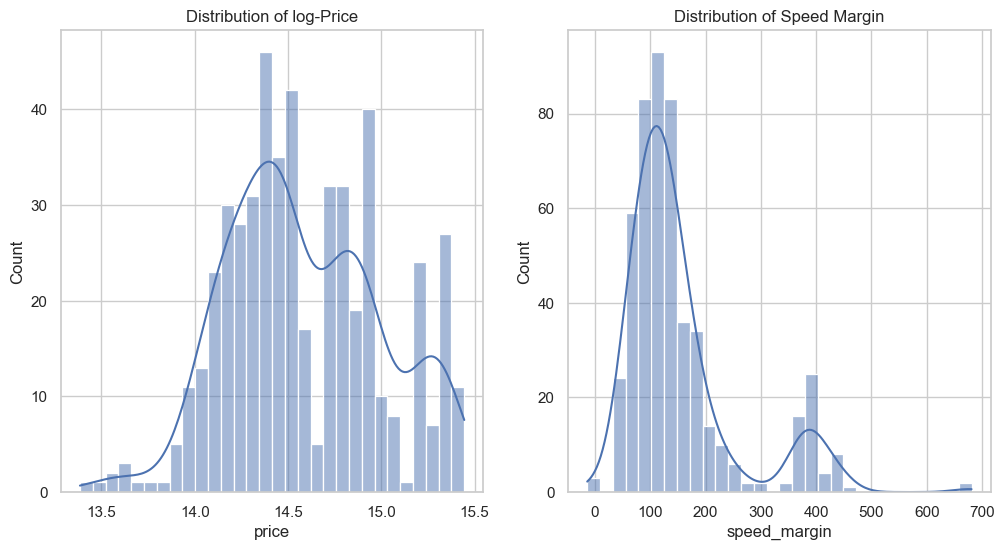

In [2598]:
## plottiamo distrubizioni di price e speed_margin
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(data['price'], bins=30, kde=True)
plt.title('Distribution of log-Price')
plt.subplot(1, 2, 2)
sns.histplot(data['speed_margin'], bins=30, kde=True)
plt.title('Distribution of Speed Margin')
plt.show()

### Predicting the price using the model

In [2599]:
# Get predictions on new input
new_df = pd.DataFrame({'speed_margin': [70,100,150,200]})
new_X = model.transform(new_df)  # Aggiungi una colonna di 1 per l'intercetta
new_X

,intercept,speed_margin
0,1.0,70
1,1.0,100
2,1.0,150
3,1.0,200


In [2600]:
New_X = sm.add_constant(new_df)
new_predictions = results.get_prediction(new_X)
predicted_means = new_predictions.predicted_mean
print(predicted_means)

[14.32767786 14.42157733 14.57807644 14.73457555]


In [2601]:
#de-log transform of predicted means
predicted_means = np.exp(predicted_means)
predicted_means = np.round(predicted_means, 2)
#stampa con due decimali
predicted_means

array([1668904.3 , 1833206.77, 2143769.82, 2506945.28])

In [2602]:
#Confidence interval
new_predictions.conf_int(alpha=0.05)

array([[14.29854234, 14.35681338],
       [14.39609065, 14.447064  ],
       [14.55546282, 14.60069005],
       [14.70976302, 14.75938808]])

In [2603]:
intercept = results.params.iloc[0]  # Intercetta (b)
slope = results.params.iloc[1]  # Pendenza (m)

formula = f"y = {slope:.4f} * speed_margin + {intercept:.4f}"

print("FORMULA del modello di regressione:", formula)

FORMULA del modello di regressione: y = 0.0031 * speed_margin + 14.1086


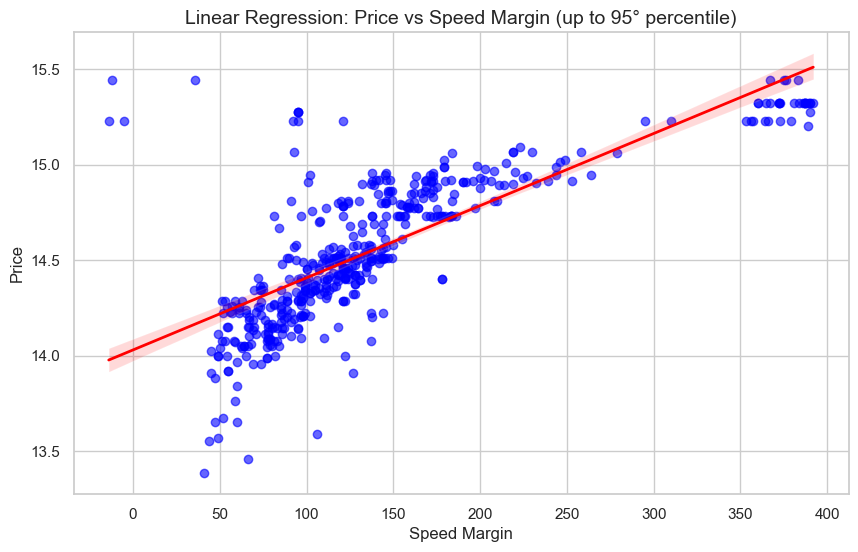

In [2604]:
# Importa seaborn per il plot
sns.set_theme(style="whitegrid")

# Filtra i dati fino al 95° percentile di speed_margin
threshold = data['speed_margin'].quantile(0.95)
filtered_data = data[data['speed_margin'] <= threshold]

# Crea il plot di regressione con intervalli di confidenza
plt.figure(figsize=(10, 6))
sns.regplot(
    x='speed_margin', 
    y=target, 
    data=filtered_data, 
    scatter_kws={'alpha': 0.6, 'color': 'blue'}, 
    line_kws={'color': 'red', 'linewidth': 2}, 
    ci=95  # Confidence interval at 95%
)

# Aggiungi titolo e etichette
plt.title("Linear Regression: Price vs Speed Margin (up to 95° percentile)", fontsize=14)
plt.xlabel("Speed Margin", fontsize=12)
plt.ylabel("Price", fontsize=12)

# Mostra il plot
plt.show()

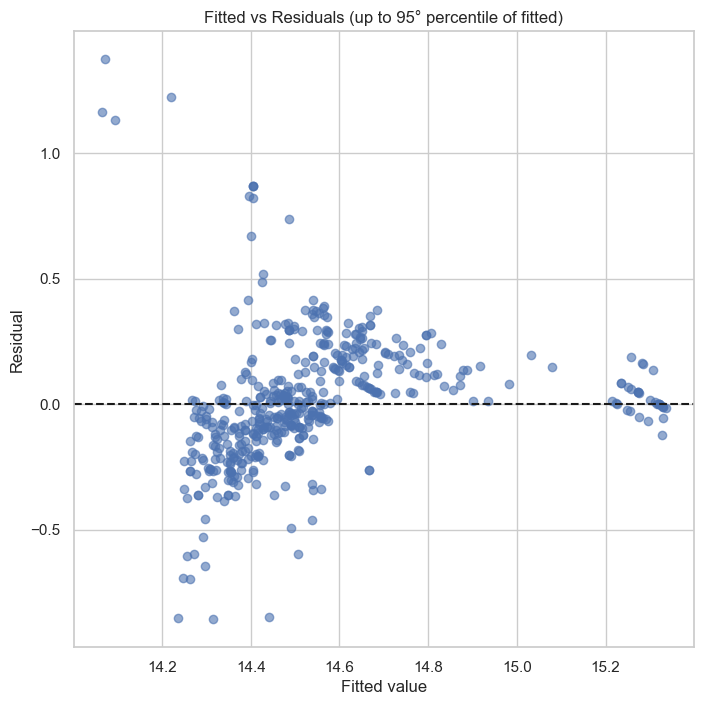

In [2605]:
fitted_95 = results.fittedvalues.quantile(0.95)

mask = results.fittedvalues <= fitted_95
fitted_filtered = results.fittedvalues[mask]
resid_filtered = results.resid[mask]

fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(fitted_filtered, resid_filtered, alpha=0.6)
ax.set_xlabel('Fitted value')
ax.set_ylabel('Residual')
ax.axhline(0, c='k', ls='--')
ax.set_title("Fitted vs Residuals (up to 95° percentile of fitted)")
plt.show()

180

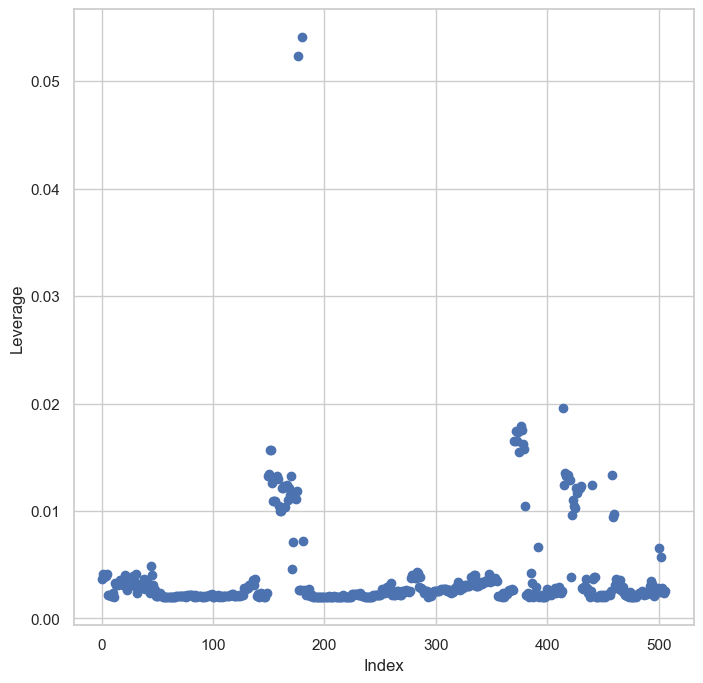

In [2606]:
# Compute leverage statistics
infl = results.get_influence()
ax = plt.subplots(figsize=(8,8))[1]
ax.scatter(np.arange(X.shape[0]), infl.hat_matrix_diag)
ax.set_xlabel('Index')
ax.set_ylabel('Leverage')
np.argmax(infl.hat_matrix_diag)

## Multiple Linear Regression

In [2607]:
# y = b*X + e (perform a regression using all of the predictors)
numeric_data = data.select_dtypes(include=[np.number])
terms = numeric_data.drop(columns=[target])
print(terms.columns)

Index(['roc_mean', 'speed_margin', 'power_per_distance', 'wing_span', 'range'], dtype='object')


In [2608]:
X= MS(terms).fit_transform(data) 
model= sm.OLS(y,X)
results= model.fit()
print(results.summary())

#mse and rmse
mse = np.mean((y - results.predict(X)) ** 2)
rmse = np.sqrt(mse)
print("RMSE: ", rmse)

#convert y de-log  trasformando e poi calcola MSE
y_pred = results.predict(X)
y_pred = np.exp(y_pred)
y_pred[:5]
y[:5]
y_true = np.exp(y)
y[:5]
mse = np.mean((y_true - y_pred) ** 2)
#RMSE
rmse = np.sqrt(mse)
print("RMSE: ", rmse)

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.715
Model:                            OLS   Adj. R-squared:                  0.712
Method:                 Least Squares   F-statistic:                     251.5
Date:                Thu, 01 May 2025   Prob (F-statistic):          4.47e-134
Time:                        18:56:16   Log-Likelihood:                 48.097
No. Observations:                 507   AIC:                            -84.19
Df Residuals:                     501   BIC:                            -58.82
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
intercept             13.6422      0

In [2609]:
#VIF
vif = pd.DataFrame()
vif['VIF'] = [VIF(X.values, i) for i in range(X.shape[1])]
vif['features'] = X.columns
vif = vif.sort_values(by='VIF', ascending=False)
vif = vif[vif['VIF'] < 10]
print(vif)

        VIF            features
5  3.534268               range
3  3.338458  power_per_distance
2  3.202497        speed_margin
1  2.966725            roc_mean
4  2.558280           wing_span


### **Commento**: abbiamo stime più robuste e interpretabili rispetto al modello con price non in log. Si perde un po’ di R² (0.78 → 0.72), ma si guadagna in stabilità

In [2610]:
significant_vars = results.pvalues[results.pvalues < 0.05]
print("\nVariabili significative (p-value < 0.05):")
print(significant_vars)

insignificant_vars = results.pvalues[results.pvalues >= 0.05]
print("\nVariabili insignificanti (p-value >= 0.05):")
print(insignificant_vars)


Variabili significative (p-value < 0.05):
intercept             0.000000e+00
roc_mean              9.847166e-16
speed_margin          1.643437e-23
power_per_distance    5.906934e-11
wing_span             4.941053e-08
range                 8.371435e-07
dtype: float64

Variabili insignificanti (p-value >= 0.05):
Series([], dtype: float64)


#### Ottimo feature engineering e selection : non abbiamo feeatures con pvalue non significativo


In [2611]:
# getting goodness of fit
print("R2", results.rsquared)
print("RSE", np.sqrt(results.scale))

R2 0.7151267351223651
RSE 0.22138512729994717


In [2612]:
#RSE delog-transformato
RSE_delog = np.sqrt(results.scale) * np.mean(np.exp(data[target]))
print("RSE", RSE_delog)

RSE 523060.9231207533


In [2613]:
#VIF su regressione lineare multipla su X
X = sm.add_constant(X)
vif_data = pd.DataFrame()
vif_data["Regressor"] = X.columns
vif_data["VIF"] = [VIF(X.values, i) for i in range(X.shape[1])]
vif_data = vif_data.sort_values("VIF", ascending=False)
print(vif_data)

            Regressor        VIF
0           intercept  42.617013
5               range   3.534268
3  power_per_distance   3.338458
2        speed_margin   3.202497
1            roc_mean   2.966725
4           wing_span   2.558280


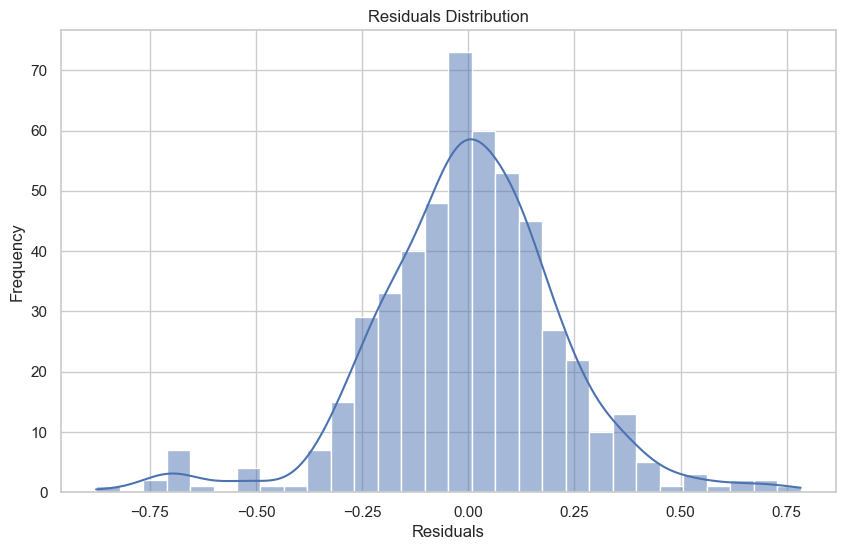

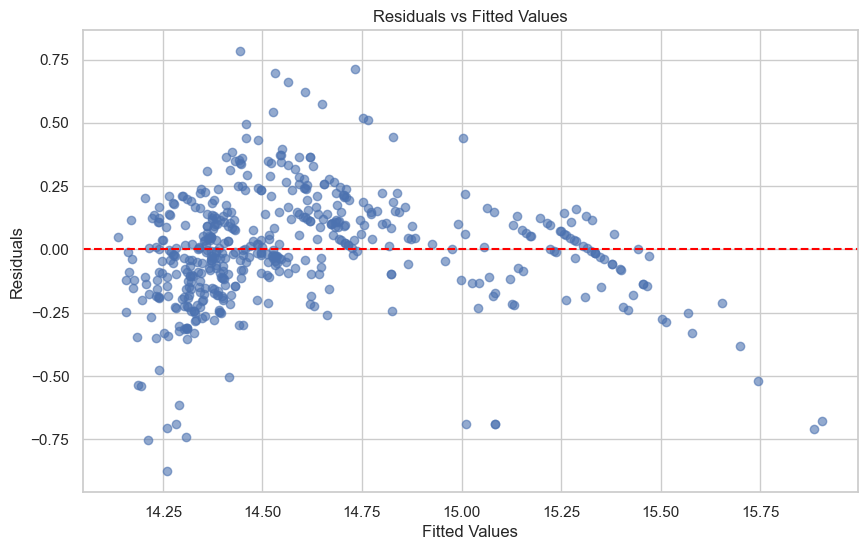

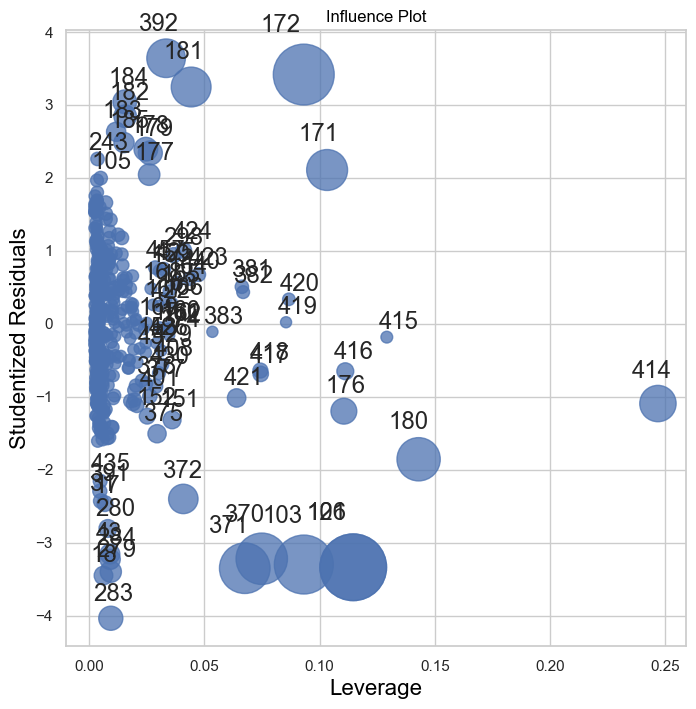

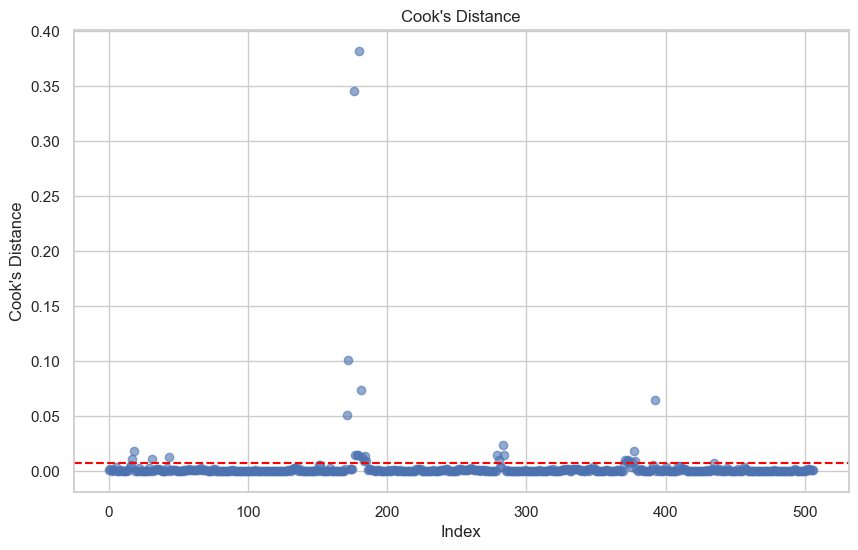

In [2614]:
#Residuals analysis
residuals = results.resid
residuals[:5]
plt.figure(figsize=(10, 6))
sns.histplot(residuals, bins=30, kde=True)
plt.title('Residuals Distribution')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()

# Residuals vs Fitted
plt.figure(figsize=(10, 6))
plt.scatter(results.fittedvalues, residuals, alpha=0.6)
plt.axhline(0, color='red', linestyle='--')
plt.title('Residuals vs Fitted Values')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.show()

# Residuals vs Leverage
fig, ax = plt.subplots(figsize=(8, 8))
sm.graphics.influence_plot(results, ax=ax, criterion="cooks")
plt.title('Influence Plot')
plt.show()

#Cooks distance
cooks_d = infl.cooks_distance[0]
cooks_d[:5]
plt.figure(figsize=(10, 6))
plt.scatter(np.arange(len(cooks_d)), cooks_d, alpha=0.6)
plt.axhline(4/len(cooks_d), color='red', linestyle='--')
plt.title('Cook\'s Distance')
plt.xlabel('Index')
plt.ylabel('Cook\'s Distance')
plt.show()


# 80-20 Cross Validation

In [2615]:
from functools import partial
from sklearn.model_selection import (cross_validate ,KFold ,ShuffleSplit)
from sklearn.base import clone
from ISLP.models import sklearn_sm #a wrapper that enables us to easily use the cross-validation tools of sklearn with models fit by statsmodels
from sklearn.model_selection import train_test_split

In [2616]:
data_train, data_test = train_test_split(data, test_size=0.2, random_state=42)
data.columns

Index(['price', 'roc_mean', 'speed_margin', 'power_per_distance', 'wing_span',
       'range'],
      dtype='object')

In [2617]:

# Specifica il modello con più variabili
# Puoi includere, ad esempio: horsepower, weight, displacement, acceleration, cylinders
hp_mm = MS(['roc_mean', 'speed_margin', 'power_per_distance', 'wing_span', 'range'])

# Costruisci le matrici X e y per il training set
X_train = hp_mm.fit_transform(data_train)
y_train = data_train['price']

# Costruisci il modello
model = sm.OLS(y_train, X_train)
results = model.fit()

# Stampa i risultati
print(results.summary())


                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.718
Model:                            OLS   Adj. R-squared:                  0.715
Method:                 Least Squares   F-statistic:                     203.5
Date:                Thu, 01 May 2025   Prob (F-statistic):          2.26e-107
Time:                        18:56:18   Log-Likelihood:                 35.555
No. Observations:                 405   AIC:                            -59.11
Df Residuals:                     399   BIC:                            -35.09
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
intercept             13.6776      0

In [2618]:
print("R2", results.rsquared)

R2 0.7182846474761861


In [2619]:
# evaluate the model using the MSE on the validation data
X_valid = hp_mm.transform(data_test)
y_valid = data_test['price']
valid_pred = results.predict(X_valid)
mse=np.mean((y_valid - valid_pred)**2)
print("MSE", mse)

MSE 0.046844768731278116


In [2620]:
# de log trasformami l'MSE
mse_de_log = mse * np.mean(np.exp(data['price']))
print("MSE de log", mse_de_log)

MSE de log 110678.92534064721


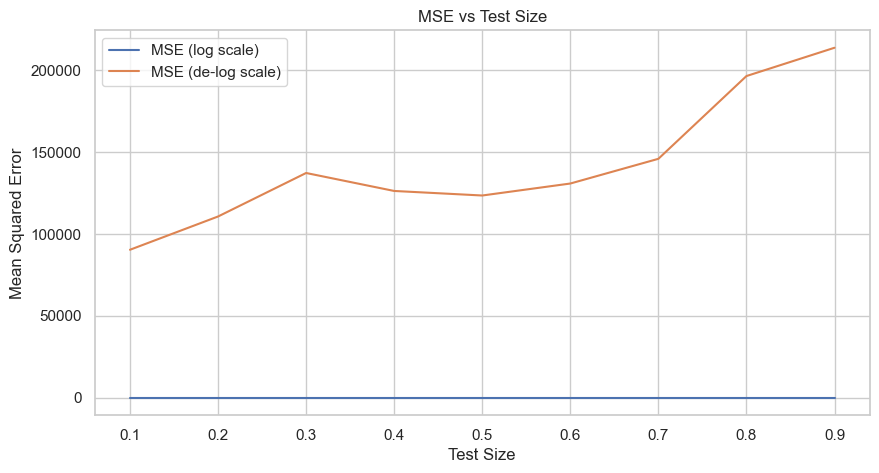

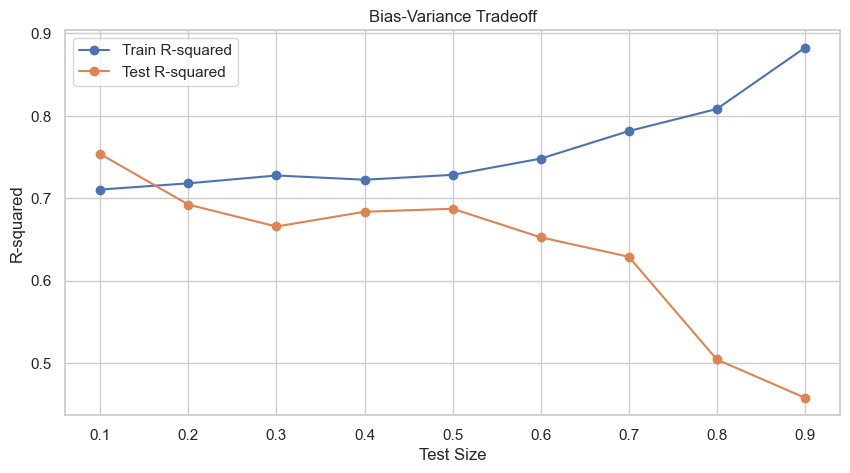

In [2621]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from ISLP.models import ModelSpec as MS
import statsmodels.api as sm

# Supponiamo che tu abbia già il tuo DataFrame chiamato `data`

test_sizes = np.linspace(0.1, 0.9, 9)
mse_list = []
mse_delog_list = []
r2_train_list = []
r2_test_list = []

features = ['roc_mean', 'speed_margin', 'power_per_distance', 'wing_span', 'range']
target = 'price'

for test_size in test_sizes:
    data_train, data_test = train_test_split(data, test_size=test_size, random_state=42)

    hp_mm = MS(features)
    X_train = hp_mm.fit_transform(data_train)
    y_train = data_train[target]

    model = sm.OLS(y_train, X_train)
    results = model.fit()

    # R^2 in train
    r2_train = results.rsquared
    r2_train_list.append(r2_train)

    # Validazione
    X_test = hp_mm.transform(data_test)
    y_test = data_test[target]
    y_pred = results.predict(X_test)

    mse = np.mean((y_test - y_pred) ** 2)
    mse_list.append(mse)

    # De-log: supponiamo che 'price' sia logaritmico
    mse_delog = mse * np.mean(np.exp(data[target]))
    mse_delog_list.append(mse_delog)

    # R² test manuale
    ss_tot = np.sum((y_test - np.mean(y_test)) ** 2)
    ss_res = np.sum((y_test - y_pred) ** 2)
    r2_test = 1 - ss_res / ss_tot
    r2_test_list.append(r2_test)

# --- PLOT 1: MSE vs Test Size ---
plt.figure(figsize=(10, 5))
plt.plot(test_sizes, mse_list, label="MSE (log scale)")
plt.plot(test_sizes, mse_delog_list, label="MSE (de-log scale)")
plt.xlabel("Test Size")
plt.ylabel("Mean Squared Error")
plt.title("MSE vs Test Size")
plt.legend()
plt.grid(True)
plt.show()

# --- PLOT 2: Bias-Variance Tradeoff ---
plt.figure(figsize=(10, 5))
plt.plot(test_sizes, r2_train_list, label="Train R-squared", marker='o')
plt.plot(test_sizes, r2_test_list, label="Test R-squared", marker='o')
plt.xlabel("Test Size")
plt.ylabel("R-squared")
plt.title("Bias-Variance Tradeoff")
plt.legend()
plt.grid(True)
plt.show()


# K=10 Fold Cross Validation

## codice libro ISLP

In [2622]:
from sklearn.linear_model import LinearRegression

# definiamo modello e dati
model = LinearRegression()
X = data.drop(columns=['price'])
Y = numeric_data['price']

# 10‐fold CV
kf = KFold(n_splits=10, shuffle=True, random_state=1)
cv_results = cross_validate(model, X, Y, cv=kf)

# errore medio (qui R² medio)
cv_err = np.mean(cv_results['test_score'])
print(cv_err)

0.6816317708340561


## codice alternativo per K=10 Fold Cross Validation e mostrare i risultati

In [2623]:
import numpy as np
import pandas as pd
from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import KFold, cross_validate

# --- 1) Prepara dati e CV ---
X = data.drop(columns=['price'])
y = numeric_data['price']
kf = KFold(n_splits=10, shuffle=True, random_state=1)

# strutture per raccogliere inferenza e metriche
coef_list, se_list, t_list, p_list, ci_lo_list, ci_hi_list = [], [], [], [], [], []
r2_list, mse_list = [], []

# --- 2) Loop sui fold ---
for train_idx, test_idx in kf.split(X):
    X_tr, X_te = X.iloc[train_idx], X.iloc[test_idx]
    y_tr, y_te = y.iloc[train_idx], y.iloc[test_idx]

    # fit sul train
    model = LinearRegression().fit(X_tr, y_tr)
    y_pred_tr = model.predict(X_tr)
    y_pred_te = model.predict(X_te)

    # inferenza sul train
    n_tr, p = X_tr.shape
    resid = y_tr - y_pred_tr
    sigma2 = np.sum(resid**2) / (n_tr - p - 1)

    X_int = np.column_stack((np.ones(n_tr), X_tr.values))
    cov = sigma2 * np.linalg.inv(X_int.T @ X_int)
    se    = np.sqrt(np.diag(cov))
    coef  = np.concatenate(([model.intercept_], model.coef_))
    tstat = coef / se
    pval  = 2 * (1 - stats.t.cdf(np.abs(tstat), df=n_tr - p - 1))
    ci    = np.vstack((coef - 1.96*se, coef + 1.96*se)).T

    # raccogli inferenza
    coef_list .append(coef)
    se_list   .append(se)
    t_list    .append(tstat)
    p_list    .append(pval)
    ci_lo_list.append(ci[:,0])
    ci_hi_list.append(ci[:,1])

    # raccogli metriche sul test
    r2_list .append(r2_score(y_te, y_pred_te))
    mse_list.append(mean_squared_error(y_te, y_pred_te))

# --- 3) Aggrega risultati inferenziali ---
coef_arr  = np.vstack(coef_list)
se_arr    = np.vstack(se_list)
t_arr     = np.vstack(t_list)
p_arr     = np.vstack(p_list)
ci_lo_arr = np.vstack(ci_lo_list)
ci_hi_arr = np.vstack(ci_hi_list)

idx = ['intercept'] + list(X.columns)
infer_df = pd.DataFrame({
    'coef_mean':  coef_arr.mean(axis=0),
    'coef_std':   coef_arr.std(axis=0),
    'se_mean':    se_arr.mean(axis=0),
    't_mean':     t_arr.mean(axis=0),
    'p_mean':     p_arr.mean(axis=0),
    'CI95_lo':    ci_lo_arr.mean(axis=0),
    'CI95_hi':    ci_hi_arr.mean(axis=0),
}, index=idx)

# --- 4) Metriche CV ---
cv_metrics = {
    'R2_mean':  np.mean(r2_list),
    'R2_std':   np.std(r2_list),
    'MSE_mean': np.mean(mse_list),
    'MSE_std':  np.std(mse_list)
}

# --- 5) Stampa ---
print("=== K-Fold CV Metrics ===")
print(f"R² mean = {cv_metrics['R2_mean']:.4f} ± {cv_metrics['R2_std']:.4f}")
print(f"MSE mean = {cv_metrics['MSE_mean']:.4f} ± {cv_metrics['MSE_std']:.4f}\n")
#RMSE delog
rmse_delog = np.sqrt(cv_metrics['MSE_mean']) * np.mean(np.exp(data['price']))
print(f"RMSE delog = {rmse_delog:.4f} ± {cv_metrics['MSE_std']:.4f}\n")
print("=== Inferential Summary (aggregato sui 10 train-fold) ===")
print(infer_df)


=== K-Fold CV Metrics ===
R² mean = 0.6816 ± 0.1019
MSE mean = 0.0519 ± 0.0187

RMSE delog = 538120.9726 ± 0.0187

=== Inferential Summary (aggregato sui 10 train-fold) ===
                    coef_mean  coef_std   se_mean      t_mean        p_mean  \
intercept           13.641785  0.014195  0.067602  201.851119  0.000000e+00   
roc_mean             0.000121  0.000011  0.000015    7.815464  2.451717e-11   
speed_margin         0.001813  0.000177  0.000181    9.986432  0.000000e+00   
power_per_distance  -0.211982  0.013966  0.033565   -6.334733  2.609367e-08   
wing_span            0.000851  0.000043  0.000162    5.258761  4.012621e-07   
range                0.000133  0.000010  0.000028    4.727239  7.959931e-06   

                      CI95_lo    CI95_hi  
intercept           13.509286  13.774285  
roc_mean             0.000090   0.000151  
speed_margin         0.001458   0.002168  
power_per_distance  -0.277769  -0.146196  
wing_span            0.000534   0.001168  
range          

Ovviamente con la crossvalidazione perdo un po’ di R².

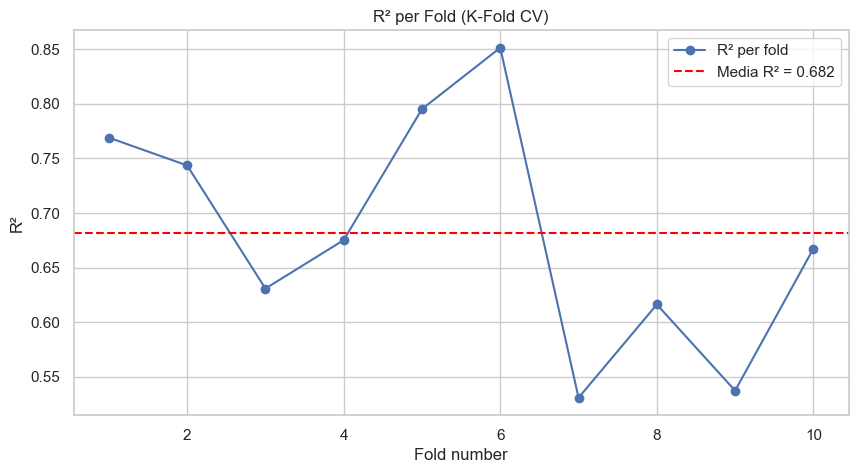

In [2624]:
mean_r2 = np.mean(r2_list)

plt.figure(figsize=(10, 5))
plt.plot(range(1, len(r2_list)+1), r2_list, marker='o', label='R² per fold')
plt.axhline(mean_r2, color='red', linestyle='--', label=f'Media R² = {mean_r2:.3f}')
plt.xlabel('Fold number')
plt.ylabel('R²')
plt.title('R² per Fold (K-Fold CV)')
plt.legend()
plt.grid(True)
plt.show()


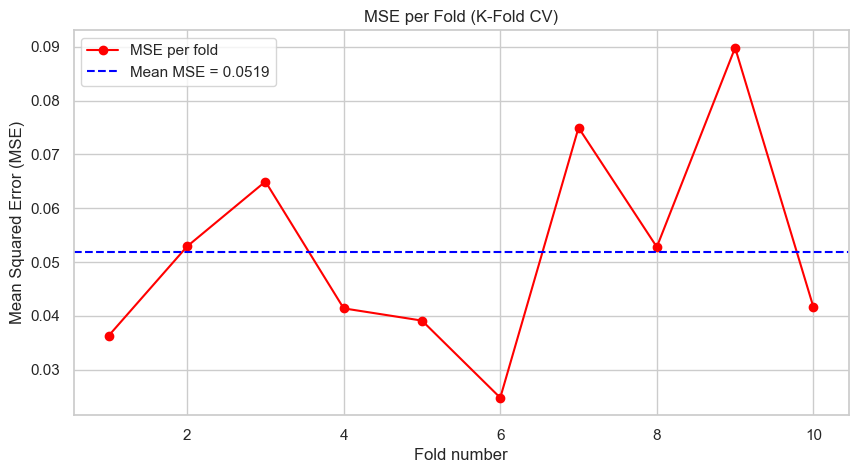

In [2625]:
mean_mse = np.mean(mse_list)

plt.figure(figsize=(10, 5))
plt.plot(range(1, len(mse_list)+1), mse_list, marker='o', color='red', label='MSE per fold')
plt.axhline(mean_mse, color='blue', linestyle='--', label=f'Mean MSE = {mean_mse:.4f}')
plt.xlabel('Fold number')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('MSE per Fold (K-Fold CV)')
plt.legend()
plt.grid(True)
plt.show()


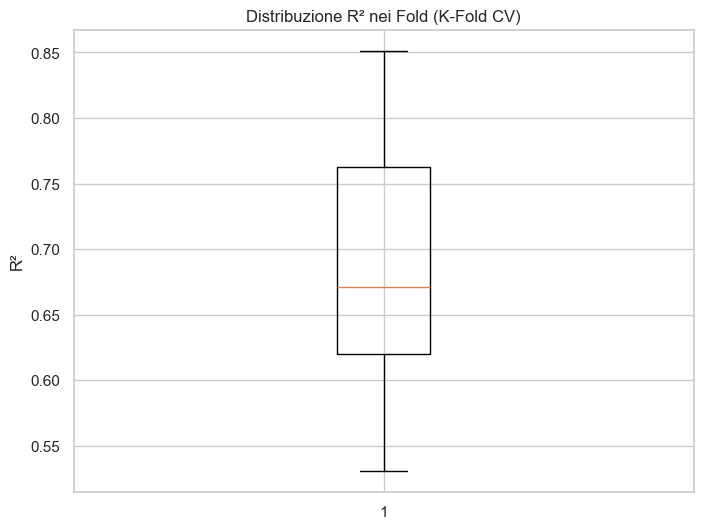

In [2626]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
plt.boxplot(r2_list, vert=True)
plt.ylabel('R²')
plt.title('Distribuzione R² nei Fold (K-Fold CV)')
plt.grid(True)
plt.show()


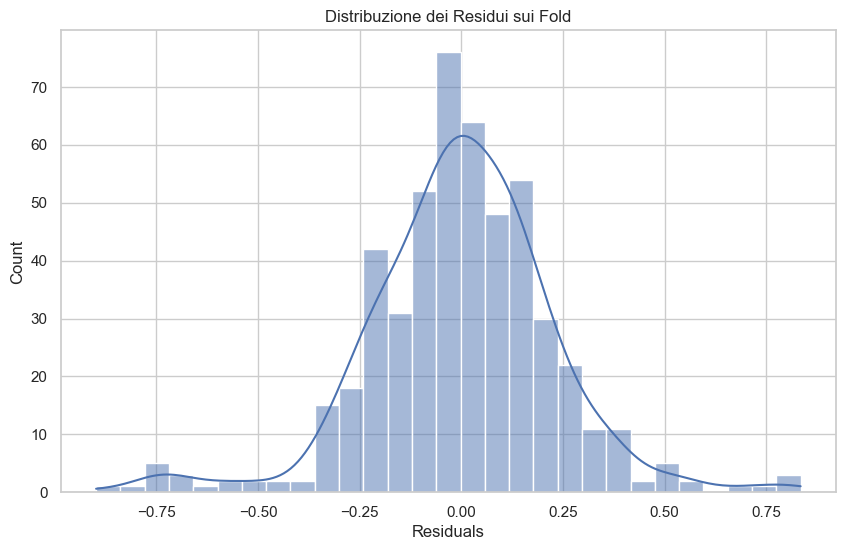

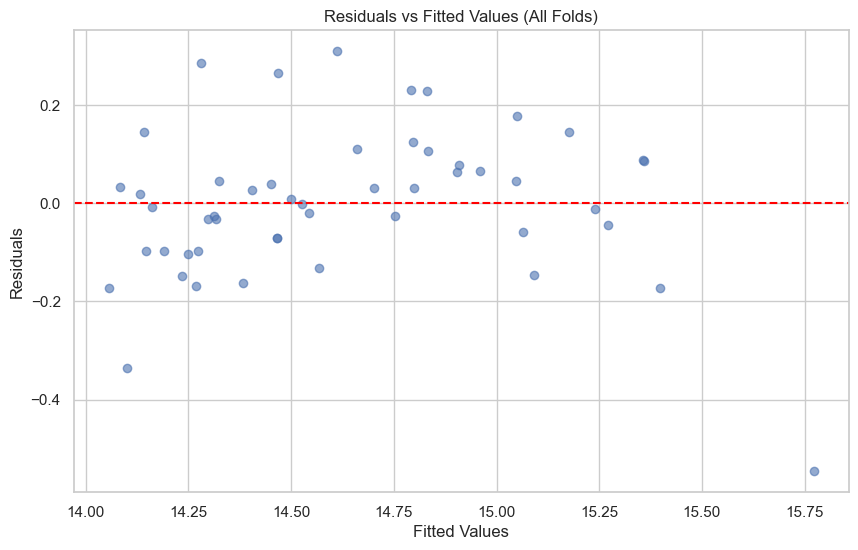

In [ ]:
import seaborn as sns

all_residuals = []  # Lista per accumulare i residui di tutti i fold

for train_idx, test_idx in kf.split(X):
    X_tr, X_te = X.iloc[train_idx], X.iloc[test_idx]
    y_tr, y_te = y.iloc[train_idx], y.iloc[test_idx]

    model = LinearRegression().fit(X_tr, y_tr)
    y_pred_te = model.predict(X_te)

    residuals = y_te - y_pred_te
    all_residuals.extend(residuals)

# Ora plotti
plt.figure(figsize=(10,6))
sns.histplot(all_residuals, kde=True)
plt.title('Distribuzione dei Residui sui Fold')
plt.xlabel('Residuals')
plt.grid(True)
plt.show()

#plot of Observed vs predicted

Il grafico mostra una distribuzione dei residui centrata attorno a zero, con una forma quasi simmetrica e leggermente asimmetrica a destra. Questo indica che il modello di regressione lineare non presenta bias evidenti e ha errori ben distribuiti. L'assenza di outlier marcati suggerisce una buona capacità predittiva e una stabilità nei diversi fold.

## Stepforward Regression using Cp

useremo tutte le variabili e ci penserà la stepforward regression a selezionare le variabili più significative

In [2628]:
from statsmodels .api import OLS
import sklearn. model_selection as skm
import sklearn. linear_model as skl
from sklearn. preprocessing import StandardScaler
from ISLP import load_data
from ISLP.models import ModelSpec as MS
from functools import partial
from sklearn. pipeline import Pipeline
from sklearn. decomposition import PCA
from sklearn. cross_decomposition import PLSRegression
from ISLP.models import \
(Stepwise ,
sklearn_selected ,
sklearn_selection_path )

In [2629]:
## data
data= pd.read_csv("Data/aircraft_price_clean.csv")

In [2630]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 507 entries, 0 to 506
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   model_name        507 non-null    object 
 1   engine_type       507 non-null    object 
 2   engine_power      507 non-null    float64
 3   max_speed         507 non-null    float64
 4   cruise_speed      507 non-null    float64
 5   stall_speed       507 non-null    float64
 6   fuel_tank         507 non-null    float64
 7   all_eng_roc       507 non-null    float64
 8   out_eng_roc       507 non-null    float64
 9   takeoff_distance  507 non-null    float64
 10  landing_distance  507 non-null    float64
 11  empty_weight      507 non-null    float64
 12  length            507 non-null    float64
 13  wing_span         507 non-null    float64
 14  range             507 non-null    float64
 15  price             507 non-null    float64
dtypes: float64(14), object(2)
memory usage: 63.5

In [2631]:
def nCp(sigma2 , estimator , X, Y):
    # Calcola il numero di parametri stimati
    n, p = X.shape
    Yhat = estimator .predict(X)
    RSS = np.sum ((Y - Yhat)**2)
    return -(RSS + 2 * p * sigma2) / n

### ⚠️ price non è log transformed dunque la log trasformo

In [2632]:
#log transform of price
data['price'] = np.log(data['price'])

In [2633]:
# Exclude non-numeric columns
numeric_columns = data.select_dtypes(include=[np.number]).columns.drop('price')
design = MS(numeric_columns).fit(data)

# Prepare the target and feature matrices
Y = np.array(data['price'])
X = design.transform(data)

# Fit the OLS model
sigma2 = OLS(Y, X).fit()

In [2634]:
neg_Cp = partial(nCp , sigma2)

In [2635]:
strategy = Stepwise . first_peak (design ,
direction ='forward ',
max_terms =len(design.terms))

In [2636]:
data_MSE = sklearn_selected (OLS ,
strategy )
data_MSE .fit(data ,Y)
data_MSE . selected_state_

('all_eng_roc',
 'cruise_speed',
 'empty_weight',
 'engine_power',
 'fuel_tank',
 'landing_distance',
 'length',
 'max_speed',
 'out_eng_roc',
 'range',
 'stall_speed',
 'takeoff_distance',
 'wing_span')

In [2637]:
# Ensure sigma2 is a numeric value (variance of residuals)
sigma2_value = sigma2.mse_resid  # Extract the mean squared error of residuals from the model

# Redefine neg_Cp with the correct sigma2 value
neg_Cp = partial(nCp, sigma2_value)

# Use the corrected neg_Cp in the sklearn_selected function
data_Cp = sklearn_selected(OLS, strategy, scoring=neg_Cp)
data_Cp.fit(data, Y)
data_Cp.selected_state_

('cruise_speed',
 'empty_weight',
 'landing_distance',
 'length',
 'max_speed',
 'out_eng_roc',
 'range',
 'stall_speed',
 'takeoff_distance',
 'wing_span')

In [2638]:
# Elenco dei predittori
selected = list(data_Cp.selected_state_)

# Matrice X con costante
X_best = sm.add_constant(data[selected])

# Risposta
y = data['price']

# Fit OLS
model_best = sm.OLS(y, X_best).fit()

# Sommario completo
print(model_best.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.825
Model:                            OLS   Adj. R-squared:                  0.821
Method:                 Least Squares   F-statistic:                     233.6
Date:                Thu, 01 May 2025   Prob (F-statistic):          1.70e-180
Time:                        18:56:25   Log-Likelihood:                 171.44
No. Observations:                 507   AIC:                            -320.9
Df Residuals:                     496   BIC:                            -274.4
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               13.3708      0.067  

In [2639]:
#VIF
vif_data = pd.DataFrame()
vif_data["Regressor"] = X_best.columns
vif_data["VIF"] = [VIF(X_best.values, i) for i in range(X_best.shape[1])]
vif_data = vif_data.sort_values("VIF", ascending=False)
print(vif_data)

           Regressor         VIF
2       empty_weight  131.174709
3   landing_distance  124.915222
0              const   75.709064
4             length   18.216475
1       cruise_speed    6.804577
10         wing_span    6.146757
6        out_eng_roc    5.567310
9   takeoff_distance    4.807463
5          max_speed    4.760926
7              range    4.183933
8        stall_speed    4.024263


In [2640]:
# Definizione della funzione per il Cp negativo
def nCp(sigma2, estimator, X, Y):
    n, p = X.shape
    Yhat = estimator.predict(X)
    RSS = np.sum((Y - Yhat) ** 2)
    return -(RSS + 2 * p * sigma2) / n

# Preparazione dei dati a partire da data2
# (assicurati che data2 sia già caricato e pulito)
numeric_cols = data.select_dtypes(include=[np.number]).columns.drop('price')
design2 = MS(numeric_cols).fit(data)

Y2 = np.array(data['price'])
X2 = design2.transform(data)

# Stima di sigma2 tramite OLS
sigma2_mod = OLS(Y2, X2).fit()
sigma2_val = sigma2_mod.mse_resid

# Scorer per Cp
neg_Cp = partial(nCp, sigma2_val)

# Strategia stepwise forward basata su Mallows Cp
strategy2 = Stepwise.first_peak(
    design2,
    direction='forward',
    max_terms=len(design2.terms)
)

# Selezione del modello
model2_Cp = sklearn_selected(OLS, strategy2, scoring=neg_Cp)
model2_Cp.fit(data, Y2)

# Variabili selezionate
print("Variabili selezionate:", model2_Cp.selected_state_)

Variabili selezionate: ('cruise_speed', 'empty_weight', 'engine_power', 'landing_distance', 'length', 'max_speed', 'out_eng_roc', 'range', 'stall_speed', 'takeoff_distance', 'wing_span')


In [2641]:
#Elenco predittori
selected2 = list(model2_Cp.selected_state_)
# Matrice X con costante
X_best2 = sm.add_constant(data[selected2])
# Risposta
y2 = data['price']
# Fit OLS
model_best2 = sm.OLS(y2, X_best2).fit()
# Sommario completo
print(model_best2.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.825
Model:                            OLS   Adj. R-squared:                  0.821
Method:                 Least Squares   F-statistic:                     212.2
Date:                Thu, 01 May 2025   Prob (F-statistic):          2.20e-179
Time:                        18:56:25   Log-Likelihood:                 171.64
No. Observations:                 507   AIC:                            -319.3
Df Residuals:                     495   BIC:                            -268.5
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               13.3549      0.072  

In [2642]:
#VIF
vif_data = pd.DataFrame()
vif_data["Regressor"] = X_best2.columns
vif_data["VIF"] = [VIF(X_best2.values, i) for i in range(X_best2.shape[1])]
vif_data = vif_data.sort_values("VIF", ascending=False)
print(vif_data)


           Regressor         VIF
4   landing_distance  145.354590
2       empty_weight  131.177339
0              const   86.454991
3       engine_power   18.434305
5             length   18.260898
1       cruise_speed    7.100331
11         wing_span    6.942790
7        out_eng_roc    5.871475
10  takeoff_distance    4.913461
6          max_speed    4.777891
9        stall_speed    4.269911
8              range    4.202926


### Stepforward regression with Cross Validation